# Data Preprocessing

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [107]:
df = pd.read_csv('./Data/Data_AWS_141223', delimiter=',')
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M')
df.dropna(inplace=True)
df.set_index('Datetime', inplace=True)
df.sort_index(ascending=False, inplace=True)
df.drop(columns=['Date', 'Time'], inplace=True)
agg_functions = {'Total': 'median'}  #
print(df.head())

                      Total
Datetime                   
2023-12-14 17:26:00  1653.0
2023-12-14 17:25:00  1651.0
2023-12-14 17:24:00  1651.0
2023-12-14 17:23:00  1649.0
2023-12-14 17:22:00  1647.0


In [108]:
df.isnull().any()
df['Total'] = df['Total'].fillna(method='ffill')


In [109]:
df = df.resample('H').bfill()
# To make data more understandle, and reduce run times.

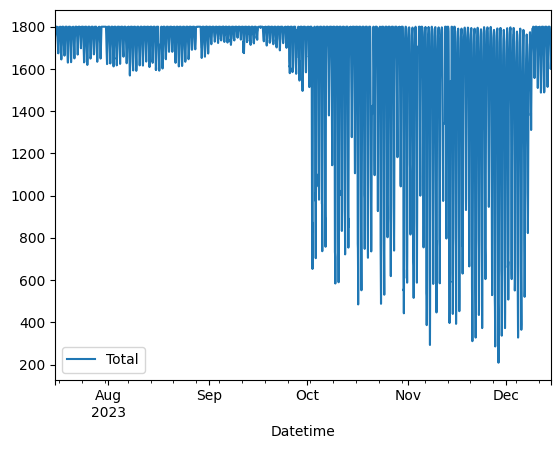

In [110]:
df.plot()
plt.show()

In [111]:
print(df.index.min(), df.index.max())

2023-07-15 17:00:00 2023-12-14 17:00:00


Summer data (start - 24/09/23) does not represent the term time trend of the data, so will omit due to limited data.

1962


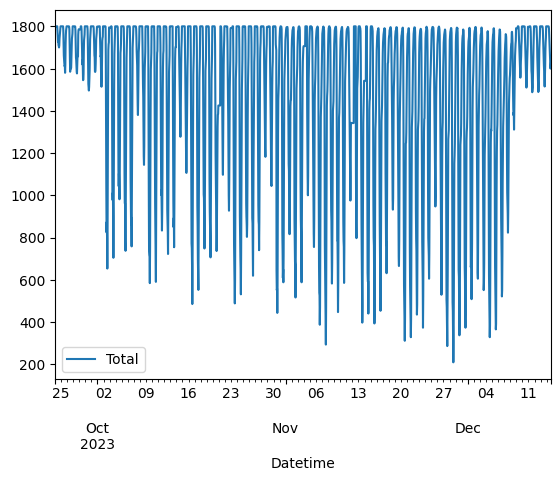

In [112]:
df = df[df.index >= '2023-09-24']
print(len(df))
df.plot()
plt.show()

In [113]:
# Add exog variables
df['Weekend'] = (df.index.dayofweek >= 5).astype(int)
print(df.tail())

                      Total  Weekend
Datetime                            
2023-12-14 13:00:00  1662.0        0
2023-12-14 14:00:00  1631.0        0
2023-12-14 15:00:00  1600.0        0
2023-12-14 16:00:00  1614.0        0
2023-12-14 17:00:00  1629.0        0


Will add day of week, and what period (summer, winter, induction week, Michaelmas term, Epiphany term and easter term) each date is, to be used as exogenous variables.

Will input dates manually, however can be trivially web-scrapped later.


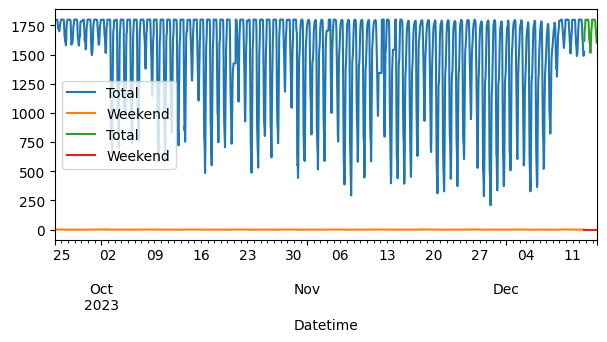

In [114]:
end_train = 48
df_train = df.iloc[:-end_train] #-400 just to visualise better
df_test  = df.iloc[-end_train:]

fig, ax=plt.subplots(figsize=(7, 3))
df_train.plot(ax=ax, label='train')
df_test.plot(ax=ax, label='test')
ax.legend();


In [123]:
import pmdarima as pmd
def find_parameters(df, col, exog_var=None, train=0.8, m=24):
    time_series_data_col = df[col].iloc[:int(len(df) * train)]

    if exog_var is not None:
        exog = df[exog_var].iloc[:int(len(df) * train)].values.reshape(-1, 1)
    else:
        exog = None

    results_auto_arima = pmd.auto_arima(y=time_series_data_col,
                                        exogenous=exog,
                                        start_p=0,
                                        start_d=0,
                                        d= 0,
                                        D= 0,
                                        start_q=0,
                                        start_P=0,
                                        start_Q=0,
                                        trend='c',
                                        seasonal=True,
                                        m=m,
                                        information_criterion='aic',
                                        trace=True,
                                        error_action='ignore',
                                        njobs=-1,
                                        )

    print(results_auto_arima)
find_parameters(df, col = 'Total', exog_var='Weekend')


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=23145.002, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=9.46 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=21033.408, Time=10.31 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=23145.002, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=21259.308, Time=0.36 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=20027.810, Time=10.61 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=19393.852, Time=7.50 sec
 ARIMA(0,0,1)(2,0,0)[24] intercept   : AIC=20500.146, Time=39.75 sec
 ARIMA(0,0,1)(2,0,1)[24] intercept   : AIC=inf, Time=39.14 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=10.27 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=18576.972, Time=9.32 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=18964.895, Time=0.92 sec
 ARIMA(1,0,1)(2,0,0)[24] intercept   : AIC=19922.545, Time=47.18 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=inf, Time=13.63 sec
 ARIMA(1,0,1)(0,0,1)[2

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.91835D+00    |proj g|=  2.55532D-01


 This problem is unconstrained.



At iterate    5    f=  6.73005D+00    |proj g|=  4.24948D-03

At iterate   10    f=  6.72963D+00    |proj g|=  4.56872D-04

At iterate   15    f=  6.72958D+00    |proj g|=  7.22351D-03

At iterate   20    f=  6.72493D+00    |proj g|=  6.49082D-02

At iterate   25    f=  6.71712D+00    |proj g|=  4.82659D-03

At iterate   30    f=  6.71679D+00    |proj g|=  1.18792D-02

At iterate   35    f=  6.04683D+00    |proj g|=  1.62143D-01

At iterate   40    f=  6.00115D+00    |proj g|=  6.39700D-02

At iterate   45    f=  5.96231D+00    |proj g|=  5.04160D-02

At iterate   50    f=  5.83826D+00    |proj g|=  3.42491D-01

At iterate   55    f=  5.70235D+00    |proj g|=  7.01081D-03

At iterate   60    f=  5.70226D+00    |proj g|=  1.47371D-04

At iterate   65    f=  5.70224D+00    |proj g|=  1.53316D-03

At iterate   70    f=  5.69634D+00    |proj g|=  7.19356D-02

At iterate   75    f=  5.67349D+00    |proj g|=  2.44264D-02

At iterate   80    f=  5.66770D+00    |proj g|=  2.71317D-03

At iter

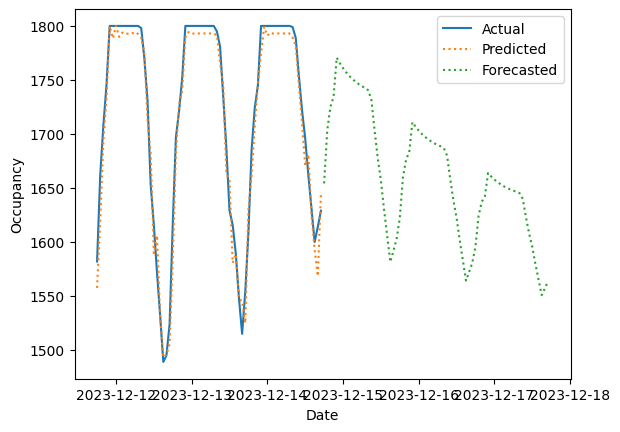

In [125]:
def sarimax_apply(df, pred_period, forecast_periods, order, seasonal_order, *args, **kwargs):
    mod = SARIMAX(endog=df['Total'],
                  exog=df['Weekend'],
                  order=order,  # 1, 0, 0
                  seasonal_order=seasonal_order,  # 1, 0, 0, 24
                  trend='c')

    results = mod.fit(maxiter=100)

    exog_forecast = df['Weekend'][-forecast_periods:].values.reshape(-1, 1)

    predicted = results.get_prediction(start=-pred_period, exog=df['Weekend'])
    forecast = results.get_forecast(steps=forecast_periods, exog=exog_forecast)

    predicted_mean_clipped = np.clip(predicted.predicted_mean, 0, 1800)
    forecast_mean_clipped = np.clip(forecast.predicted_mean, 0, 1800)

    plt.plot(df.index[-pred_period:], df['Total'][-pred_period:], label='Actual')
    plt.plot(predicted.predicted_mean.index, predicted_mean_clipped, label='Predicted', linestyle='dotted')
    plt.plot(forecast.predicted_mean.index, forecast_mean_clipped, label='Forecasted', linestyle='dotted')

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Occupancy')
    plt.show()

sarimax_apply(df, pred_period=72, forecast_periods=72, order = (1,0,1), seasonal_order=(1,0,0,24))